In [1]:
# STEP 1 — Kaggle setup (local) + download Credit Card Fraud dataset (anomaly detection)

import os, sys, zipfile, subprocess, pathlib, json

# === Fill these from your Kaggle API token (Kaggle -> Account -> Create New API Token) ===
KAGGLE_USERNAME = "iamvijayshankar"
KAGGLE_KEY      = "5432ac578dbd76cbbfa10a1935b6e4aa"
# =========================================================================================

KAGGLE_DATASET = "mlg-ulb/creditcardfraud"      # Credit Card Fraud (anomaly detection)
DATA_ROOT      = os.path.abspath("./data")
DATASET_DIR    = os.path.join(DATA_ROOT, "creditcard_anomaly")

print("KAGGLE_DATASET:", KAGGLE_DATASET)
print("DATA_ROOT:", DATA_ROOT)
print("DATASET_DIR:", DATASET_DIR)

# 1) Ensure Kaggle CLI is installed for this Python
subprocess.run([sys.executable, "-m", "pip", "install", "-q", "kaggle"], check=True)

# 2) Write ~/.kaggle/kaggle.json from creds above (or reuse if already present)
home = str(pathlib.Path.home())
kaggle_dir = os.path.join(home, ".kaggle")
kaggle_json = os.path.join(kaggle_dir, "kaggle.json")
os.makedirs(kaggle_dir, exist_ok=True)
if not KAGGLE_USERNAME or not KAGGLE_KEY:
    raise ValueError("Please set KAGGLE_USERNAME and KAGGLE_KEY (from your kaggle.json).")

with open(kaggle_json, "w") as f:
    json.dump({"username": KAGGLE_USERNAME, "key": KAGGLE_KEY}, f)
try:
    os.chmod(kaggle_json, 0o600)  # ok if this no-ops on Windows
except Exception:
    pass

# Also set env vars for Kaggle CLI
os.environ["KAGGLE_USERNAME"] = KAGGLE_USERNAME
os.environ["KAGGLE_KEY"] = KAGGLE_KEY

# 3) Create data folders
os.makedirs(DATA_ROOT, exist_ok=True)
os.makedirs(DATASET_DIR, exist_ok=True)

# 4) Download zip to DATA_ROOT
print("\nDownloading from Kaggle…")
subprocess.run([
    "kaggle", "datasets", "download",
    "-d", KAGGLE_DATASET,
    "-p", DATA_ROOT,
    "--force"
], check=True)

# 5) Unzip every .zip found in DATA_ROOT into DATASET_DIR
for fname in os.listdir(DATA_ROOT):
    if fname.lower().endswith(".zip"):
        zpath = os.path.join(DATA_ROOT, fname)
        print("Unzipping:", zpath)
        with zipfile.ZipFile(zpath, "r") as zf:
            zf.extractall(DATASET_DIR)
        os.remove(zpath)

print("\nContents of dataset directory:")
for f in os.listdir(DATASET_DIR):
    print(" -", f)

KAGGLE_DATASET: mlg-ulb/creditcardfraud
DATA_ROOT: /Users/spartan/Documents/data
DATASET_DIR: /Users/spartan/Documents/data/creditcard_anomaly

Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0

Unzipping: /Users/spartan/Documents/data/creditcardfraud.zip


100%|██████████| 66.0M/66.0M [00:00<00:00, 1.99GB/s]



Contents of dataset directory:
 - creditcard.csv


In [2]:
# STEP 2 — Load CSV, sanity checks, handle imbalance info, scale Time/Amount, stratified split

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# Paths (must match Step 1)
DATA_ROOT   = os.path.abspath("./data")
DATASET_DIR = os.path.join(DATA_ROOT, "creditcard_anomaly")
CSV_PATH    = os.path.join(DATASET_DIR, "creditcard.csv")

# 2.1 Load
df = pd.read_csv(CSV_PATH)
print("Loaded:", CSV_PATH)
print("Shape:", df.shape)
display(df.head())

# 2.2 Basic checks
print("\nColumns:", list(df.columns))
print("\nMissing values per column:\n", df.isna().sum())
print("\nDuplicates (before drop):", df.duplicated().sum())

if df.duplicated().any():
    df = df.drop_duplicates().reset_index(drop=True)
    print("Duplicates removed. New shape:", df.shape)

# 2.3 Target & class imbalance snapshot
TARGET = "Class"  # 1 = fraud, 0 = normal
assert TARGET in df.columns, f"Expected target '{TARGET}' not found."

class_counts = df[TARGET].value_counts().sort_index()
fraud_ratio = class_counts.get(1, 0) / class_counts.sum()
print("\nClass counts:\n", class_counts.to_string())
print(f"Fraud ratio: {fraud_ratio:.5f}  (~1 is rare, 0 is common)")

# 2.4 Features / label
# PCA components are already scaled-ish (V1..V28). Only 'Time' and 'Amount' need robust scaling.
y = df[TARGET].astype(int)
X = df.drop(columns=[TARGET]).copy()

# 2.5 Robust scaling of Time & Amount (resistant to outliers)
scaler = RobustScaler()
for col in ["Time", "Amount"]:
    if col in X.columns:
        X[col] = scaler.fit_transform(X[[col]])
    else:
        print(f"Warning: column '{col}' not found — skipping scaling.")

# 2.6 Stratified split (preserves rare fraud ratio across splits)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\nTrain: {X_train.shape} | Valid: {X_valid.shape}")
print("Class balance (train):", (y_train.value_counts(normalize=True).sort_index()).to_dict())
print("Class balance (valid):", (y_valid.value_counts(normalize=True).sort_index()).to_dict())

# 2.7 Class weights (helpful for many classifiers)
neg, pos = class_counts.get(0, 0), class_counts.get(1, 0)
if pos > 0:
    weight_pos = neg / pos
    class_weight = {0: 1.0, 1: float(weight_pos)}
else:
    class_weight = {0: 1.0, 1: 1.0}

print("\nSuggested class_weight for imbalanced training:", class_weight)

# Keep for next step:
# X_train, X_valid, y_train, y_valid, class_weight, scaler, feature_cols
feature_cols = list(X.columns)


Loaded: /Users/spartan/Documents/data/creditcard_anomaly/creditcard.csv
Shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0



Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

Missing values per column:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Duplicates (before drop): 1081
Duplicates removed. New shape: (283726, 31)

Class counts:
 Class
0    283253
1       473
Fraud ratio: 0.00167  (~1 is rare, 0 is common)

Train: (226980, 30) | Valid: (56746, 30)
Class balance (train): {0: 0.998334655035686, 1: 0.0016653449643140364}
Class balance (valid): {0: 0.9983258731892997, 1: 0.0016741268107003137}

Sug

=== Logistic Regression (supervised) ===
ROC-AUC: 0.9657 | PR-AUC: 0.6719
Best F1 on valid: 0.7177 @ threshold=0.99

Classification report @ best-F1 threshold:
               precision    recall  f1-score   support

           0     0.9996    0.9993    0.9995     56651
           1     0.6579    0.7895    0.7177        95

    accuracy                         0.9990     56746
   macro avg     0.8288    0.8944    0.8586     56746
weighted avg     0.9991    0.9990    0.9990     56746


=== Isolation Forest (unsupervised) ===
ROC-AUC: 0.9348 | PR-AUC: 0.1114


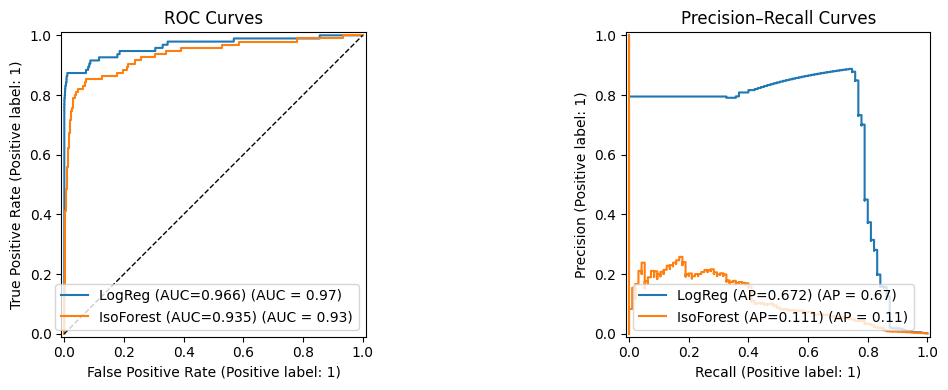

In [3]:
# STEP 3 — Baselines: (A) Logistic Regression (supervised, class_weight) 
#                      (B) Isolation Forest (unsupervised)
# Evaluation: ROC-AUC, PR-AUC, curves, and best-F1 threshold for Logistic

import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    RocCurveDisplay, PrecisionRecallDisplay,
    classification_report, f1_score
)

# ----------------------------
# (A) Logistic Regression (supervised)
# ----------------------------
logit = Pipeline([
    ("scale", StandardScaler(with_mean=False)),  # sparse-friendly; safe for mixed scales
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight=class_weight,   # handles imbalance
        n_jobs=-1,
        solver="lbfgs"
    ))
])

logit.fit(X_train, y_train)
proba_lr = logit.predict_proba(X_valid)[:, 1]  # fraud probability

roc_lr = roc_auc_score(y_valid, proba_lr)
pr_lr  = average_precision_score(y_valid, proba_lr)

# pick a threshold that maximizes F1 on validation
ths = np.linspace(0.01, 0.99, 99)
f1s = [f1_score(y_valid, (proba_lr >= t).astype(int)) for t in ths]
best_idx = int(np.argmax(f1s))
best_t = float(ths[best_idx])
best_f1 = float(f1s[best_idx])
pred_lr = (proba_lr >= best_t).astype(int)

print("=== Logistic Regression (supervised) ===")
print(f"ROC-AUC: {roc_lr:.4f} | PR-AUC: {pr_lr:.4f}")
print(f"Best F1 on valid: {best_f1:.4f} @ threshold={best_t:.2f}")
print("\nClassification report @ best-F1 threshold:\n",
      classification_report(y_valid, pred_lr, digits=4))

# ----------------------------
# (B) Isolation Forest (unsupervised)
# ----------------------------
iso = IsolationForest(
    n_estimators=300,
    contamination="auto",   # lets IF estimate the anomaly fraction
    random_state=42,
    n_jobs=-1
)
iso.fit(X_train)  # unlabeled fit

# decision_function: higher = more normal, lower = more anomalous
score_iso = -iso.decision_function(X_valid)  # flip so higher = more anomalous (like "fraudier")
roc_iso = roc_auc_score(y_valid, score_iso)
pr_iso  = average_precision_score(y_valid, score_iso)

print("\n=== Isolation Forest (unsupervised) ===")
print(f"ROC-AUC: {roc_iso:.4f} | PR-AUC: {pr_iso:.4f}")

# ----------------------------
# Plots: ROC and PR curves (both models)
# ----------------------------
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# ROC
RocCurveDisplay.from_predictions(y_valid, proba_lr, name=f"LogReg (AUC={roc_lr:.3f})", ax=ax[0])
RocCurveDisplay.from_predictions(y_valid, score_iso, name=f"IsoForest (AUC={roc_iso:.3f})", ax=ax[0])
ax[0].plot([0,1],[0,1],'k--',linewidth=1)
ax[0].set_title("ROC Curves")

# PR
PrecisionRecallDisplay.from_predictions(y_valid, proba_lr, name=f"LogReg (AP={pr_lr:.3f})", ax=ax[1])
PrecisionRecallDisplay.from_predictions(y_valid, score_iso, name=f"IsoForest (AP={pr_iso:.3f})", ax=ax[1])
ax[1].set_title("Precision–Recall Curves")
plt.tight_layout()
plt.show()

# Keep for next step:
# logit (trained), iso (trained), proba_lr (valid probabilities), best_t (threshold), score_iso

In [4]:
# STEP 4 — Calibrate probs, pick cost-sensitive threshold, save artifact, reload & smoke test

import numpy as np, pandas as pd, os, joblib
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_recall_fscore_support
)

# ---------- 4.1 Probability calibration (isotonic) ----------
# We have a prefit LogisticRegression pipeline `logit` from Step 3.
# Calibrate on validation to improve probability quality.
cal = CalibratedClassifierCV(logit, method="isotonic", cv="prefit")
cal.fit(X_valid, y_valid)  # uses the validation labels to calibrate probabilities

proba_lr_cal = cal.predict_proba(X_valid)[:, 1]
roc_cal = roc_auc_score(y_valid, proba_lr_cal)
pr_cal  = average_precision_score(y_valid, proba_lr_cal)

# Compare against the uncalibrated scores from Step 3 (proba_lr)
roc_uncal = roc_auc_score(y_valid, proba_lr)
pr_uncal  = average_precision_score(y_valid, proba_lr)

print("=== Probability Quality (Validation) ===")
print(f"Uncalibrated  -> ROC-AUC: {roc_uncal:.4f} | PR-AUC: {pr_uncal:.4f}")
print(f"Calibrated    -> ROC-AUC: {roc_cal:.4f} | PR-AUC: {pr_cal:.4f}")

# We'll use whichever has better PR-AUC (more meaningful for imbalance)
use_calibrated = pr_cal >= pr_uncal
proba_use = proba_lr_cal if use_calibrated else proba_lr
chosen_model = cal if use_calibrated else logit
print("Using", "CALIBRATED" if use_calibrated else "UNCALIBRATED", "probabilities going forward.")

# ---------- 4.2 Cost-sensitive threshold selection ----------
# Define your cost matrix (you can tune these):
#   - False Negative (miss a fraud) is expensive
#   - False Positive (flag a normal as fraud) is cheaper but still costs review time
COST_FN = 20.0   # cost for a missed fraud
COST_FP = 1.0    # cost for a false alarm

ths = np.linspace(0.01, 0.99, 99)
def eval_threshold(y_true, scores, t):
    pred = (scores >= t).astype(int)
    # confusion counts
    tn = np.sum((y_true==0) & (pred==0))
    fp = np.sum((y_true==0) & (pred==1))
    fn = np.sum((y_true==1) & (pred==0))
    tp = np.sum((y_true==1) & (pred==1))
    cost = COST_FN*fn + COST_FP*fp
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, pred, average="binary", zero_division=0)
    return dict(t=t, cost=cost, F1=f1, precision=prec, recall=rec, fp=fp, fn=fn, tp=tp, tn=tn)

stats = [eval_threshold(y_valid.values, proba_use, t) for t in ths]
best_cost_idx = int(np.argmin([s["cost"] for s in stats]))
best_cost_t   = float(stats[best_cost_idx]["t"])
best_cost     = float(stats[best_cost_idx]["cost"])
best_cost_f1  = float(stats[best_cost_idx]["F1"])

# Also keep the best-F1 threshold as a reference
best_f1_idx = int(np.argmax([s["F1"] for s in stats]))
best_f1_t   = float(stats[best_f1_idx]["t"])
best_f1     = float(stats[best_f1_idx]["F1"])

print("\n=== Threshold Search (Validation) ===")
print(f"Min-Cost threshold: t={best_cost_t:.2f} | expected cost={best_cost:.1f} | F1 at t={best_cost_f1:.3f}")
print(f"Best-F1 threshold : t={best_f1_t:.2f} | F1={best_f1:.3f}")

# Pick the operational threshold (prefer minimizing expected cost)
operating_threshold = best_cost_t

# ---------- 4.3 Save production artifact ----------
os.makedirs("./artifacts", exist_ok=True)
artifact = {
    "model": chosen_model,                # Calibrated model (CalibratedClassifierCV) or raw pipeline
    "calibrated": bool(use_calibrated),
    "threshold": float(operating_threshold),
    "features": feature_cols,            # from Step 2
    "class_weight": class_weight,        # from Step 2 (useful for documentation)
    "costs": {"FN": COST_FN, "FP": COST_FP},
}
artifact_path = "./artifacts/creditcard_fraud_detector.joblib"
joblib.dump(artifact, artifact_path)
print(f"\n✅ Saved artifact to: {artifact_path}")
print(f"   Includes: calibrated={artifact['calibrated']}, threshold={artifact['threshold']:.2f}, features={len(artifact['features'])}")

# ---------- 4.4 Reload & smoke test ----------
loaded = joblib.load(artifact_path)
mdl      = loaded["model"]
thr      = loaded["threshold"]
features = loaded["features"]

# Ensure feature alignment
Xv = X_valid[features].copy()

# Get probabilities (CalibratedClassifierCV and LogisticRegression both support predict_proba)
p = mdl.predict_proba(Xv)[:, 1]
pred = (p >= thr).astype(int)

print("\nSmoke test on first 5 validation rows:")
for i in range(min(5, len(Xv))):
    print(f"Row{i+1}: proba={p[i]:.4f} -> pred={pred[i]} | true={int(y_valid.iloc[i])}")

# Tiny helper for later batch inference
def predict_fraud_labels(df_new: pd.DataFrame, artifact_file: str = artifact_path) -> np.ndarray:
    """
    Load the saved artifact and return binary fraud predictions for df_new.
    df_new MUST contain the same columns (features) used in training.
    """
    art = joblib.load(artifact_file)
    mdl = art["model"]
    thr = art["threshold"]
    cols = art["features"]
    proba = mdl.predict_proba(df_new[cols])[:, 1]
    return (proba >= thr).astype(int)

print("\nHelper `predict_fraud_labels(df_new)` is ready to use.")

=== Probability Quality (Validation) ===
Uncalibrated  -> ROC-AUC: 0.9657 | PR-AUC: 0.6719
Calibrated    -> ROC-AUC: 0.9726 | PR-AUC: 0.7215
Using CALIBRATED probabilities going forward.

=== Threshold Search (Validation) ===
Min-Cost threshold: t=0.03 | expected cost=432.0 | F1 at t=0.743
Best-F1 threshold : t=0.26 | F1=0.814

✅ Saved artifact to: ./artifacts/creditcard_fraud_detector.joblib
   Includes: calibrated=True, threshold=0.03, features=30

Smoke test on first 5 validation rows:
Row1: proba=0.0001 -> pred=0 | true=0
Row2: proba=0.0001 -> pred=0 | true=0
Row3: proba=0.0001 -> pred=0 | true=0
Row4: proba=0.0001 -> pred=0 | true=0
Row5: proba=0.0009 -> pred=0 | true=0

Helper `predict_fraud_labels(df_new)` is ready to use.
